# Setup

In [1]:
!pip install -U -q transformers bitsandbytes accelerate sentence-transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.0 MB/s eta 0:00

In [2]:
from sentence_transformers import SentenceTransformer, util

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

from sklearn.cluster import KMeans

from datasets import load_dataset

from math import sqrt

## Create the sentence-embedder

In [3]:
class SentenceEncoder():
    def __init__(self, model='sentence-transformers/all-MiniLM-L12-v2', device='cuda'):
        self.model = SentenceTransformer(model, device)
        pass
    
    def encode(self, sentences, convert_to_tensor=True):
        return self.model.encode(sentences, convert_to_tensor=convert_to_tensor)

## Method to setup the summarizer pipeline

In [4]:
def create_summarizer_pipeline(params=None):
  default_params = {
                      "max_length": 256,
                      "min_length": 8,
                      "no_repeat_ngram_size": 3,
                      "early_stopping": True,
                      "repetition_penalty": 3.5,
                      "length_penalty": 0.4,
                      "encoder_no_repeat_ngram_size": 3,
                      "num_beams": 4
                } # parameters for text generation out of model
  params = params if params else default_params
  params['load_in_8bit'] = True
  model_name = "pszemraj/long-t5-tglobal-xl-16384-book-summary-8bit"
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
  summarizer = pipeline(task="summarization",\
                        model=model,\
                        tokenizer=tokenizer,\
                        device_map="auto",\
                        model_kwargs=params)
  return summarizer

# Clustering Algorithms

## kmeans

In [5]:
def cluster_k_means(corpus, corpus_embeddings, num_clusters=None):
  if num_clusters is None:
    num_clusters = int(sqrt(len(corpus)))
  clustering_model = KMeans(n_clusters=num_clusters)
  clustering_model.fit(corpus_embeddings)
  cluster_assignment = clustering_model.labels_
  clustered_sentences = [[] for i in range(num_clusters)]
  clustered_embeddings = [[] for i in range(num_clusters)]
  for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])
    clustered_embeddings[cluster_id].append(corpus_embeddings[sentence_id])
  return clustered_sentences, clustered_embeddings, cluster_assignment

# Dimensionality Reduction

## PCA

# Experiment: Quora Duplicate Questions Dataset

In [6]:
def get_quora_questions_slice(slice_n=None):
  sliced_quora = load_dataset("quora", split="train")[:slice_n] if slice_n else load_dataset("quora", split="train")
  labels = sliced_quora['is_duplicate']
  questions = []
  for q in sliced_quora['questions']:
    questions.append(q['text'][0])
    questions.append(q['text'][1])
  return questions, labels

In [7]:
questions, labels = get_quora_questions_slice(slice_n=10000)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

Dataset quora downloaded and prepared to /root/.cache/huggingface/datasets/quora/default/0.0.0/36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04. Subsequent calls will reuse this data.


In [8]:
st = SentenceEncoder()

In [12]:
embed_questions = st.encode(questions)

In [16]:
embed_questions_cpu = embed_questions.detach().cpu().numpy()

In [29]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(embed_questions_cpu)

PCA()

In [38]:
len(pca.explained_variance_ratio_)

384

In [41]:
cdf = [pca.explained_variance_ratio_[0]]
for i in range(1,len(pca.explained_variance_ratio_)):
  cdf.append(cdf[-1] + pca.explained_variance_ratio_[i])

In [47]:
pca = PCA(n_components=200)
pca.fit(embed_questions_cpu)

PCA(n_components=200)

In [75]:
pca.fit(embed_questions_cpu)
X = pca.transform(embed_questions_cpu)

In [76]:
import numpy as np

In [83]:
X = [x/np.linalg.norm(x) for x in X]

In [84]:
X[0]

1.0

In [67]:
np.linalg.norm(X, axis=1)

array([0.9031376 , 0.9014432 , 0.8445676 , ..., 0.8390931 , 0.9170233 ,
       0.88705134], dtype=float32)

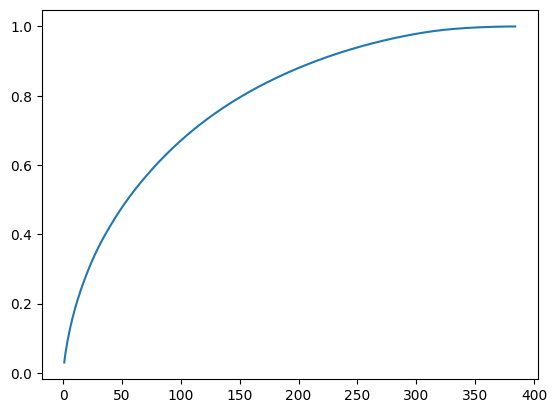

In [43]:
import numpy as np
import matplotlib.pyplot as plt

x,y = [x for x in range(1, len(cdf)+1)], cdf
fig, ax = plt.subplots()
ax.plot(x, y)

In [47]:
clustered_sentences, clustered_embeddings, cluster_assignment = cluster_k_means(corpus=questions,\
                                                            corpus_embeddings=embed_questions.cpu(),\
                                                            num_clusters=None)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [48]:
cluster_sizes = [len(cluster) for cluster in clustered_sentences]

In [56]:
long_texts = [" ".join(clustered_sentences[i]) for i in range(len(clustered_sentences))]

In [53]:
summarizer = create_summarizer_pipeline()


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('8013'), PosixPath('http'), PosixPath('//172.28.0.1')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --

In [ ]:
cluster_summaries = summarizer(long_texts)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:816: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Your max_length is set to 1024, but you input_length is only 842. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=421)
Your max_length is set to 1024, but you input_length is only 966. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=483)
Your max_length is set to 1024, but you input_length is only 964. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=482)
Your max_length is set to 1024, but you input_length is only 796. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=398)
Your max_length is set to 1024, but you input_length is only 827. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=413)
Your max_length is set to 1024, b